In [ ]:
# Initialize Otter
import otter
grader = otter.Notebook("hw3_loss_functions_and_fitting_models.ipynb")

# HW3

Name: Sicheng Yi (Tiger Yi)

Email: tigeryi@bu.edu

ID: U43188754


### Completing the notebook on Colab

To complete the notebook on Colab, you can click on the "Open in Colab" button
below and it will open the notebook from our public class notebook repository
on GitHub.

> Note that you will have save the notebook to your own Google Drive by clicking
on File -> Save a Copy in Drive.

> Also note that the Otter Grader cells will not run in Colab, but you can just
> avoid executing those cells. For any public tests, you can submit to Gradescope
> and inspect your results there.

<a href="https://colab.research.google.com/github/DL4DS/sp2025_homeworks/blob/main/hw3/hw3_loss_functions_and_fitting_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Completing the notebook in a local environment

For local environments, after setting up your Python and Jupyter environments,
you have the option of using either
* Jupyter Lab or Notebook interface, or with
* VSCode and the Jupyter extension pack

In both cases we strongly encourage you to make sure you have a recent version
of Python (>=3.10) and use a virtual environment such as `venv` or miniconda
environment.

# **3.1 Multiclass Cross-Entropy Loss**

The following cells investigates the multi-class cross-entropy loss.

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.


In [1]:
# Imports math library
import numpy as np
# Used for repmat
import numpy.matlib
# Imports plotting library
import matplotlib.pyplot as plt
# Import math Library
import math

In [2]:
# Define the Rectified Linear Unit (ReLU) function
def ReLU(preactivation):
  activation = preactivation.clip(0.0)
  return activation

# Define a shallow neural network
def shallow_nn(x, beta_0, omega_0, beta_1, omega_1):
    # Make sure that input data is (1 x n_data) array
    n_data = x.size
    x = np.reshape(x,(1,n_data))

    # This runs the network for ALL of the inputs, x at once so we can draw graph
    h1 = ReLU(np.matmul(beta_0,np.ones((1,n_data))) + np.matmul(omega_0,x))
    model_out = np.matmul(beta_1,np.ones((1,n_data))) + np.matmul(omega_1,h1)
    return model_out


In [3]:
# Get parameters for model -- we can call this function to easily reset them
def get_parameters():
  # And we'll create a network that approximately fits it
  beta_0 = np.zeros((3,1));  # formerly theta_x0
  omega_0 = np.zeros((3,1)); # formerly theta_x1
  beta_1 = np.zeros((3,1));  # NOTE -- there are three outputs now (one for each class, so three output biases)
  omega_1 = np.zeros((3,3)); # NOTE -- there are three outputs now (one for each class, so nine output weights, connecting 3 hidden units to 3 outputs)

  beta_0[0,0] = 0.3; beta_0[1,0] = -1.0; beta_0[2,0] = -0.5
  omega_0[0,0] = -1.0; omega_0[1,0] = 1.8; omega_0[2,0] = 0.65
  beta_1[0,0] = 2.0; beta_1[1,0] = -2; beta_1[2,0] = 0.0
  omega_1[0,0] = -24.0; omega_1[0,1] = -8.0; omega_1[0,2] = 50.0
  omega_1[1,0] = -2.0; omega_1[1,1] = 8.0; omega_1[1,2] = -30.0
  omega_1[2,0] = 16.0; omega_1[2,1] = -8.0; omega_1[2,2] =-8

  return beta_0, omega_0, beta_1, omega_1

In [22]:
# Utility function for plotting data
def plot_multiclass_classification(x_model, out_model, lambda_model, x_data = None, y_data = None, title= None):
  # Make sure model data are 1D arrays
  n_data = len(x_model)
  n_class = 3
  x_model = np.squeeze(x_model)
  out_model = np.reshape(out_model, (n_class,n_data))
  lambda_model = np.reshape(lambda_model, (n_class,n_data))

  fig, ax = plt.subplots(1,2)
  fig.set_size_inches(7.0, 3.5)
  fig.tight_layout(pad=3.0)
  ax[0].plot(x_model,out_model[0,:],'r-')
  ax[0].plot(x_model,out_model[1,:],'g-')
  ax[0].plot(x_model,out_model[2,:],'b-')
  ax[0].set_xlabel('Input, $x$'); ax[0].set_ylabel('Model outputs')
  ax[0].set_xlim([0,1]);ax[0].set_ylim([-4,4])
  if title is not None:
    ax[0].set_title(title)
  ax[1].plot(x_model,lambda_model[0,:],'r-')
  ax[1].plot(x_model,lambda_model[1,:],'g-')
  ax[1].plot(x_model,lambda_model[2,:],'b-')
  ax[1].set_xlabel('Input, $x$'); ax[1].set_ylabel('$\lambda$ or Pr(y=k|x)')
  ax[1].set_xlim([0,1]);ax[1].set_ylim([-0.1,1.05])
  if title is not None:
    ax[1].set_title(title)
  if x_data is not None:
    for i in range(len(x_data)):
      if y_data[i] ==0:
        ax[1].plot(x_data[i],-0.05, 'r.')
      if y_data[i] ==1:
        ax[1].plot(x_data[i],-0.05, 'g.')
      if y_data[i] ==2:
        ax[1].plot(x_data[i],-0.05, 'b.')
  # i add this line
  plt.legend(['class 0','class 1','class 2'])
  plt.show()


# Multiclass classification

For multiclass classification, the network must predict the probability of $K$ classes, using $K$ outputs.  However, these probability must be non-negative and sum to one, and the network outputs can take arbitrary values.  Hence, we pass the outputs through a softmax function which maps $K$ arbitrary values to $K$ non-negative values that sum to one.

#### 3.1.1 Compute the softmax function

In [9]:
# Softmax function that maps a vector of arbitrary values to a vector of values that are positive and sum to one.
def softmax(model_out):
  # Compute the exponential of the model outputs
  exp_model_out = np.exp(model_out)

  # Compute the sum of the exponentials (denominator of equation 5.22)
  sum_exp_model_out = np.sum(exp_model_out, axis=0, keepdims=True)

  # Normalize the exponentials (np.matlib.repmat might be useful here)
  softmax_model_out = exp_model_out / sum_exp_model_out

  return softmax_model_out


In [10]:

# Let's create some 1D training data
x_train = np.array([0.09291784,0.46809093,0.93089486,0.67612654,0.73441752,0.86847339,\
                   0.49873225,0.51083168,0.18343972,0.99380898,0.27840809,0.38028817,\
                   0.12055708,0.56715537,0.92005746,0.77072270,0.85278176,0.05315950,\
                   0.87168699,0.58858043])
y_train = np.array([2,0,1,2,1,0,\
                    0,2,2,0,2,0,\
                    2,0,1,2,1,2, \
                    1,0])

# Get parameters for the model
beta_0, omega_0, beta_1, omega_1 = get_parameters()

# Define a range of input values
x_model = np.arange(0,1,0.01)


In [35]:
x_train.shape, y_train.shape


((20,), (20,))

In [11]:
# Run the model to get values to plot and plot it.
model_out= shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)


In [12]:
model_out.shape


(3, 100)

In [13]:
lambda_model = softmax(model_out)


In [24]:
lambda_model.shape


(3, 100)

In [32]:
lambda_model[:,0:4]

array([[4.53701373e-05, 6.76746285e-05, 1.00940766e-04, 1.50552465e-04],
       [6.10851644e-04, 7.31217787e-04, 8.75271277e-04, 1.04765711e-03],
       [9.99343778e-01, 9.99201108e-01, 9.99023788e-01, 9.98801790e-01]])

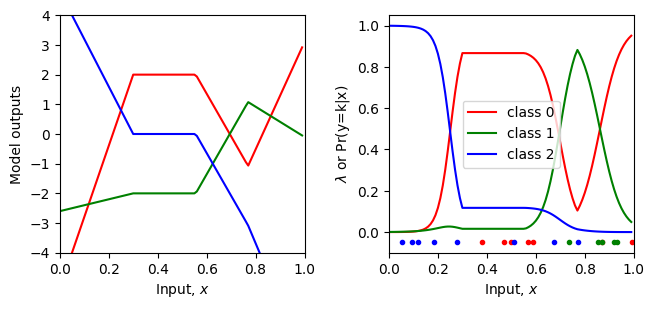

In [25]:
plot_multiclass_classification(x_model, model_out, lambda_model, x_train, y_train)


The left is model output and the right is the model output after the softmax has been applied, so it now lies in the range [0,1] and represents the probability, that y=0 (red), 1 (green) and 2 (blue).  The dots at the bottom show the training data with the same color scheme.  So we want the red curve to be high where there are red dots, the green curve to be high where there are green dots, and the blue curve to be high where there are blue dots  We'll compute the likelihood and the negative log likelihood.

In [33]:
# Return probability under categorical distribution for observed class y
# Just take value from row k of lambda param where y = k,
def categorical_distribution(y, lambda_param):
    return np.array([lambda_param[row, i] for i, row in enumerate (y)])


In [34]:
# Here are three examples
print(categorical_distribution(np.array([[0]]),np.array([[0.2],[0.5],[0.3]])))
print(categorical_distribution(np.array([[1]]),np.array([[0.2],[0.5],[0.3]])))
print(categorical_distribution(np.array([[2]]),np.array([[0.2],[0.5],[0.3]])))


[[0.2]]
[[0.5]]
[[0.3]]


#### 3.1.2 Compute likelihood scores

<!-- BEGIN QUESTION -->



In [56]:
# Return the likelihood of all of the data under the model
def compute_likelihood(y_train, lambda_param):
  # TODO -- compute the likelihood of the data

  likelihood_arr = categorical_distribution(y_train, lambda_param)
  likelihood = likelihood_arr.prod()

  return likelihood


<!-- END QUESTION -->



In [57]:
# Let's test this
beta_0, omega_0, beta_1, omega_1 = get_parameters()

# Use our neural network to predict the parameters of the categorical distribution
model_out = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
lambda_train = softmax(model_out)


In [58]:
# y_train.shape == (20,)

In [59]:
# lambda_train.shape == (3, 20)

In [60]:
# Compute the likelihood
likelihood = compute_likelihood(y_train, lambda_train)

likelihood


4.076435184442612e-08

In [61]:
# Let's double check we get the right answer before proceeding
print("Correct answer = %9.9f, Your answer = %9.9f"%(0.000000041,likelihood))


Correct answer = 0.000000041, Your answer = 0.000000041


You can see that this gives a very small answer, even for this small 1D dataset, and with the model fitting quite well.  This is because it is the product of several probabilities, which are all quite small themselves.
This will get out of hand pretty quickly with real datasets -- the likelihood will get so small that we can't represent it with normal finite-precision math

This is why we use negative log likelihood

#### 3.1.3 Compute the negative log likelihood

<!-- BEGIN QUESTION -->



In [62]:
# Return the negative log likelihood of the data under the model
def compute_negative_log_likelihood(y_train, lambda_param):

  likelihood_arr = categorical_distribution(y_train, lambda_param)

  likelihood_arr_log = np.log(likelihood_arr)

  nll = -1*likelihood_arr_log.sum()

  return nll


In [66]:
# Let's test this
beta_0, omega_0, beta_1, omega_1 = get_parameters()
# Use our neural network to predict the parameters of the categorical distribution
model_out = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
# Pass the outputs through the softmax function
lambda_train = softmax(model_out)
# Compute the negative log likelihood
nll = compute_negative_log_likelihood(y_train, lambda_train)
# Let's double check we get the right answer before proceeding
print("Correct answer = %9.9f, Your answer = %9.9f"%(17.015457867,nll))

Correct answer = 17.015457867, Your answer = 17.015457867


In [63]:
# Let's test this
beta_0, omega_0, beta_1, omega_1 = get_parameters()
# Use our neural network to predict the parameters of the categorical distribution
model_out = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
# Pass the outputs through the softmax function
lambda_train = softmax(model_out)


In [64]:
# Compute the negative log likelihood
nll = compute_negative_log_likelihood(y_train, lambda_train)
nll


17.01545786676351

In [65]:
# Let's double check we get the right answer before proceeding
print("Correct answer = %9.9f, Your answer = %9.9f"%(17.015457867,nll))


Correct answer = 17.015457867, Your answer = 17.015457867


<!-- END QUESTION -->

Now let's investigate finding the maximum likelihood / minimum negative log likelihood solution.  For simplicity, we'll assume that all the parameters are fixed except one and look at how the likelihood and negative log likelihood change as we manipulate the last parameter.  We'll start with overall y_offset, $\beta_1$ (formerly $\phi_0$)

In [67]:
# Define a range of values for the parameter
beta_1_vals = np.arange(-2,6.0,0.1)
# Create some arrays to store the likelihoods, negative log likelihoods
likelihoods = np.zeros_like(beta_1_vals)
nlls = np.zeros_like(beta_1_vals)


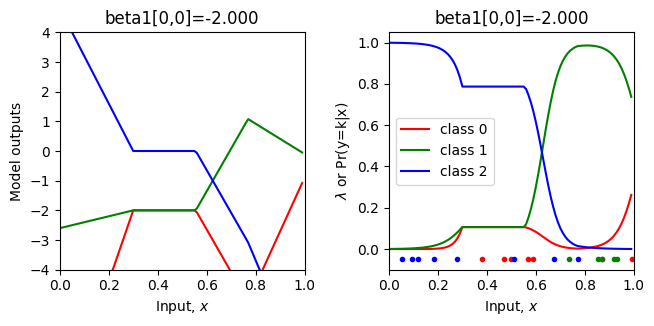

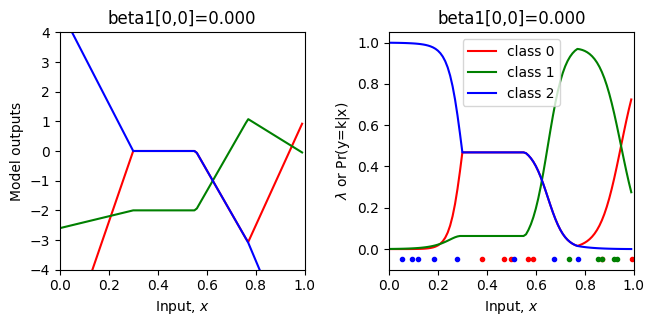

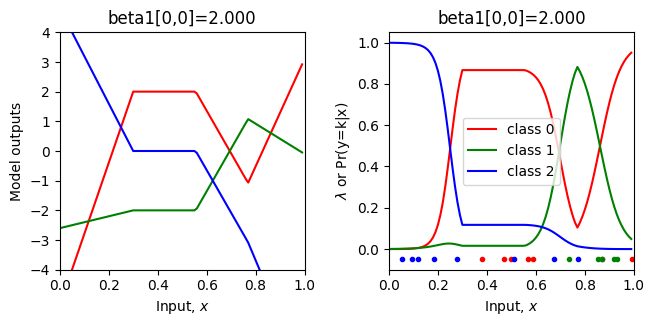

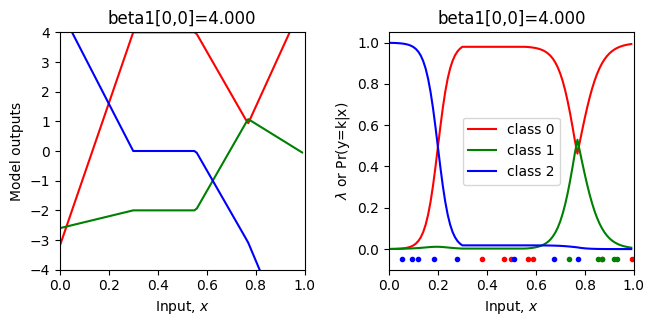

In [68]:
# Initialise the parameters
beta_0, omega_0, beta_1, omega_1 = get_parameters()
for count in range(len(beta_1_vals)):
  # Set the value for the parameter
  beta_1[0,0] = beta_1_vals[count]
  # Run the network with new parameters
  model_out = shallow_nn(x_train, beta_0, omega_0, beta_1, omega_1)
  lambda_train = softmax(model_out)
  # Compute and store the two values
  likelihoods[count] = compute_likelihood(y_train,lambda_train)
  nlls[count] = compute_negative_log_likelihood(y_train, lambda_train)
  # Draw the model for every 20th parameter setting
  if count % 20 == 0:
    # Run the model to get values to plot and plot it.
    model_out = shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
    lambda_model = softmax(model_out)
    plot_multiclass_classification(x_model, model_out, lambda_model, x_train, y_train, title="beta1[0,0]=%3.3f"%(beta_1[0,0]))


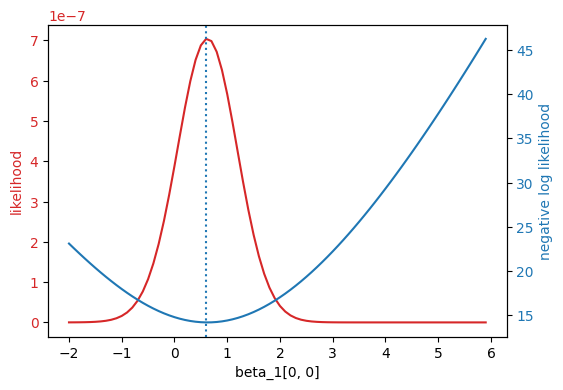

In [69]:
# Now let's plot the likelihood and negative log likelihood as a function of the value of the offset beta1
fig, ax = plt.subplots()
fig.tight_layout(pad=5.0)
likelihood_color = 'tab:red'
nll_color = 'tab:blue'

ax.set_xlabel('beta_1[0, 0]')
ax.set_ylabel('likelihood', color = likelihood_color)
ax.plot(beta_1_vals, likelihoods, color = likelihood_color)
ax.tick_params(axis='y', labelcolor=likelihood_color)

ax1 = ax.twinx()
ax1.plot(beta_1_vals, nlls, color = nll_color)
ax1.set_ylabel('negative log likelihood', color = nll_color)
ax1.tick_params(axis='y', labelcolor = nll_color)

plt.axvline(x = beta_1_vals[np.argmax(likelihoods)], linestyle='dotted')

plt.show()


In [70]:
# Hopefully, you can see that the maximum of the likelihood fn is at the same position as the minimum negative log likelihood solution
# Let's check that:
print("Maximum likelihood = %f, at beta_1=%3.3f"%( (likelihoods[np.argmax(likelihoods)],beta_1_vals[np.argmax(likelihoods)])))
print("Minimum negative log likelihood = %f, at beta_1=%3.3f"%( (nlls[np.argmin(nlls)],beta_1_vals[np.argmin(nlls)])))


Maximum likelihood = 0.000001, at beta_1=0.600
Minimum negative log likelihood = 14.166574, at beta_1=0.600


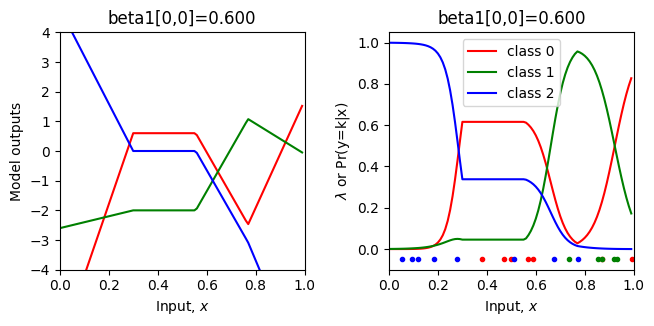

In [71]:
# Plot the best model
beta_1[0,0] = beta_1_vals[np.argmin(nlls)]
model_out = shallow_nn(x_model, beta_0, omega_0, beta_1, omega_1)
lambda_model = softmax(model_out)
plot_multiclass_classification(x_model, model_out, lambda_model, x_train, y_train, title="beta1[0,0]=%3.3f"%(beta_1[0,0]))


They both give the same answer. But you can see from the likelihood above that the likelihood is very small unless the parameters are almost correct.  So in practice, we would work with the negative log likelihood.<br><br>

Again, to fit the full neural model we would vary all of the 16 parameters of the network in the $\boldsymbol\beta_{0},\boldsymbol\Omega_{0},\boldsymbol\beta_{1},\boldsymbol\Omega_{1}$ until we find the combination that have the maximum likelihood / minimum negative log likelihood.<br><br>



# **3.2 Adam**

The following cells investigates the Adam optimizer as illustrated in figure 6.9 from the book.


In [72]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [73]:
# Define function that we wish to find the minimum of (normally would be defined implicitly by data and loss)
def loss(phi0, phi1):
    height = np.exp(-0.5 * (phi1 * phi1)*4.0)
    height = height * np. exp(-0.5* (phi0-0.7) *(phi0-0.7)/4.0)
    return 1.0-height

# Compute the gradients of this function (for simplicity, I just used finite differences)
def get_loss_gradient(phi0, phi1):
    delta_phi = 0.00001;
    gradient = np.zeros((2,1));
    gradient[0] = (loss(phi0+delta_phi/2.0, phi1) - loss(phi0-delta_phi/2.0, phi1))/delta_phi
    gradient[1] = (loss(phi0, phi1+delta_phi/2.0) - loss(phi0, phi1-delta_phi/2.0))/delta_phi
    return gradient[:,0];

# Compute the loss function at a range of values of phi0 and phi1 for plotting
def get_loss_function_for_plot():
  grid_values = np.arange(-1.0,1.0,0.01);
  phi0mesh, phi1mesh = np.meshgrid(grid_values, grid_values)
  loss_function = np.zeros((grid_values.size, grid_values.size))
  for idphi0, phi0 in enumerate(grid_values):
      for idphi1, phi1 in enumerate(grid_values):
          loss_function[idphi0, idphi1] = loss(phi1,phi0)
  return loss_function, phi0mesh, phi1mesh


In [74]:
# Define fancy colormap
my_colormap_vals_hex =('2a0902', '2b0a03', '2c0b04', '2d0c05', '2e0c06', '2f0d07', '300d08', '310e09', '320f0a', '330f0b', '34100b', '35110c', '36110d', '37120e', '38120f', '39130f', '3a1410', '3b1411', '3c1511', '3d1612', '3e1613', '3f1713', '401714', '411814', '421915', '431915', '451a16', '461b16', '471b17', '481c17', '491d18', '4a1d18', '4b1e19', '4c1f19', '4d1f1a', '4e201b', '50211b', '51211c', '52221c', '53231d', '54231d', '55241e', '56251e', '57261f', '58261f', '592720', '5b2821', '5c2821', '5d2922', '5e2a22', '5f2b23', '602b23', '612c24', '622d25', '632e25', '652e26', '662f26', '673027', '683027', '693128', '6a3229', '6b3329', '6c342a', '6d342a', '6f352b', '70362c', '71372c', '72372d', '73382e', '74392e', '753a2f', '763a2f', '773b30', '783c31', '7a3d31', '7b3e32', '7c3e33', '7d3f33', '7e4034', '7f4134', '804235', '814236', '824336', '834437', '854538', '864638', '874739', '88473a', '89483a', '8a493b', '8b4a3c', '8c4b3c', '8d4c3d', '8e4c3e', '8f4d3f', '904e3f', '924f40', '935041', '945141', '955242', '965343', '975343', '985444', '995545', '9a5646', '9b5746', '9c5847', '9d5948', '9e5a49', '9f5a49', 'a05b4a', 'a15c4b', 'a35d4b', 'a45e4c', 'a55f4d', 'a6604e', 'a7614e', 'a8624f', 'a96350', 'aa6451', 'ab6552', 'ac6552', 'ad6653', 'ae6754', 'af6855', 'b06955', 'b16a56', 'b26b57', 'b36c58', 'b46d59', 'b56e59', 'b66f5a', 'b7705b', 'b8715c', 'b9725d', 'ba735d', 'bb745e', 'bc755f', 'bd7660', 'be7761', 'bf7862', 'c07962', 'c17a63', 'c27b64', 'c27c65', 'c37d66', 'c47e67', 'c57f68', 'c68068', 'c78169', 'c8826a', 'c9836b', 'ca846c', 'cb856d', 'cc866e', 'cd876f', 'ce886f', 'ce8970', 'cf8a71', 'd08b72', 'd18c73', 'd28d74', 'd38e75', 'd48f76', 'd59077', 'd59178', 'd69279', 'd7937a', 'd8957b', 'd9967b', 'da977c', 'da987d', 'db997e', 'dc9a7f', 'dd9b80', 'de9c81', 'de9d82', 'df9e83', 'e09f84', 'e1a185', 'e2a286', 'e2a387', 'e3a488', 'e4a589', 'e5a68a', 'e5a78b', 'e6a88c', 'e7aa8d', 'e7ab8e', 'e8ac8f', 'e9ad90', 'eaae91', 'eaaf92', 'ebb093', 'ecb295', 'ecb396', 'edb497', 'eeb598', 'eeb699', 'efb79a', 'efb99b', 'f0ba9c', 'f1bb9d', 'f1bc9e', 'f2bd9f', 'f2bfa1', 'f3c0a2', 'f3c1a3', 'f4c2a4', 'f5c3a5', 'f5c5a6', 'f6c6a7', 'f6c7a8', 'f7c8aa', 'f7c9ab', 'f8cbac', 'f8ccad', 'f8cdae', 'f9ceb0', 'f9d0b1', 'fad1b2', 'fad2b3', 'fbd3b4', 'fbd5b6', 'fbd6b7', 'fcd7b8', 'fcd8b9', 'fcdaba', 'fddbbc', 'fddcbd', 'fddebe', 'fddfbf', 'fee0c1', 'fee1c2', 'fee3c3', 'fee4c5', 'ffe5c6', 'ffe7c7', 'ffe8c9', 'ffe9ca', 'ffebcb', 'ffeccd', 'ffedce', 'ffefcf', 'fff0d1', 'fff2d2', 'fff3d3', 'fff4d5', 'fff6d6', 'fff7d8', 'fff8d9', 'fffada', 'fffbdc', 'fffcdd', 'fffedf', 'ffffe0')
my_colormap_vals_dec = np.array([int(element,base=16) for element in my_colormap_vals_hex])
r = np.floor(my_colormap_vals_dec/(256*256))
g = np.floor((my_colormap_vals_dec - r *256 *256)/256)
b = np.floor(my_colormap_vals_dec - r * 256 *256 - g * 256)
my_colormap_vals = np.vstack((r,g,b)).transpose()/255.0
my_colormap = ListedColormap(my_colormap_vals)

# Plotting function
def draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, opt_path):
    fig = plt.figure();
    ax = plt.axes();
    fig.set_size_inches(7,7)
    ax.contourf(phi0mesh, phi1mesh, loss_function, 256, cmap=my_colormap);
    ax.contour(phi0mesh, phi1mesh, loss_function, 20, colors=['#80808080'])
    ax.plot(opt_path[0,:], opt_path[1,:],'-', color='#a0d9d3ff')
    ax.plot(opt_path[0,:], opt_path[1,:],'.', color='#a0d9d3ff',markersize=10)
    ax.set_xlabel(r"$\phi_{0}$")
    ax.set_ylabel(r"$\phi_{1}$")
    plt.show()

In [75]:
# Simple fixed step size gradient descent
def grad_descent(start_posn, n_steps, alpha):
    grad_path = np.zeros((2, n_steps+1));
    grad_path[:,0] = start_posn[:,0];
    for c_step in range(n_steps):
        this_grad = get_loss_gradient(grad_path[0,c_step], grad_path[1,c_step]);
        grad_path[:,c_step+1] = grad_path[:,c_step] - alpha * this_grad
    return grad_path;


We'll start by running gradient descent with a fixed step size for this loss function.

In [76]:
loss_function, phi0mesh, phi1mesh = get_loss_function_for_plot() ;

start_posn = np.zeros((2,1));
start_posn[0,0] = -0.7; start_posn[1,0] = -0.9


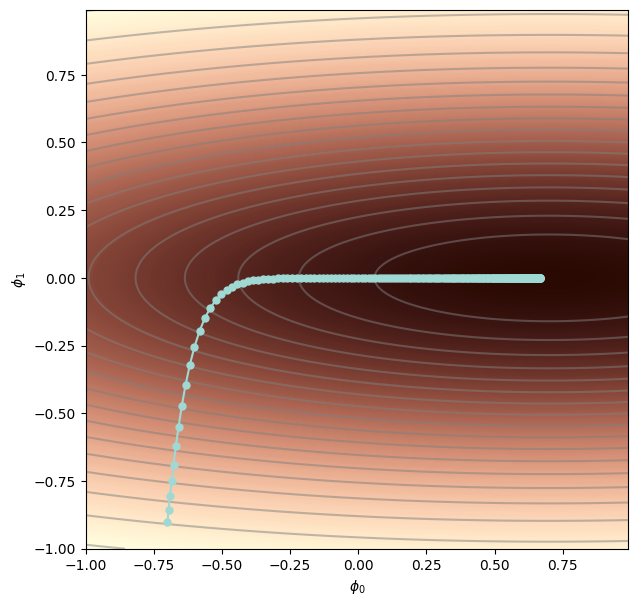

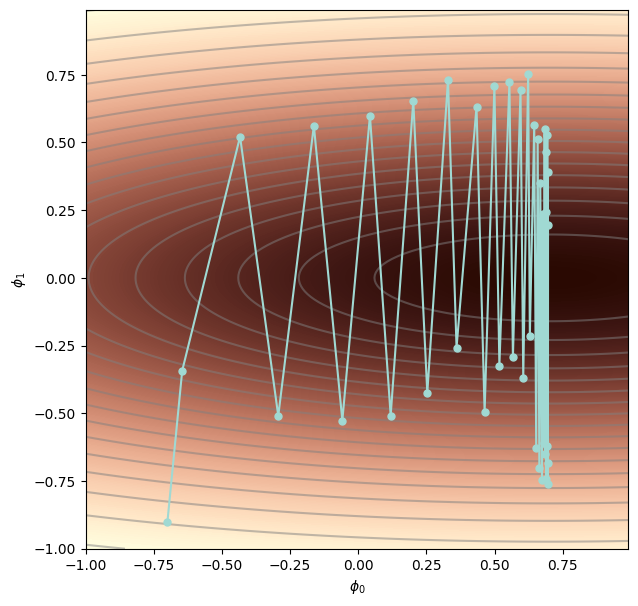

In [77]:
# Run gradient descent
grad_path1 = grad_descent(start_posn, n_steps=200, alpha = 0.08)
draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path1)

grad_path2 = grad_descent(start_posn, n_steps=40, alpha= 1.0)
draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path2)


Because the function changes much faster in $\phi_1$ than in $\phi_0$, there is no great step size to choose.  If we set the step size so that it makes sensible progress in the $\phi_1$ direction, then it takes many iterations to converge.  If we set the step size so that we make sensible progress in the $\phi_0$ direction, then the path oscillates in the $\phi_1$ direction.  

This motivates Adam.  At the core of Adam is the idea that we should just determine which way is downhill along each axis (i.e. left/right for $\phi_0$ or up/down for $\phi_1$) and move a fixed distance in that direction.

#### 3.2.1 Complete the below code.

<!-- BEGIN QUESTION -->



In [80]:
def normalized_gradients(start_posn, n_steps, alpha,  epsilon=1e-20):
    grad_path = np.zeros((2, n_steps+1));
    grad_path[:,0] = start_posn[:,0];

    for c_step in range(n_steps):

        # Measure the gradient as in equation 6.13 (first line)
        m = get_loss_gradient(grad_path[0,c_step], grad_path[1,c_step]);

        # TODO -- compute the squared gradient as in equation 6.13 (second line)
        # Replace this line:
        v = np.square(get_loss_gradient(grad_path[0,c_step], grad_path[1,c_step]))

        # TODO -- apply the update rule (equation 6.14)
        # Replace this line:
        grad_path[:,c_step+1] = grad_path[:,c_step] - alpha * m / (np.sqrt(v) + epsilon)

    return grad_path;


<!-- END QUESTION -->



In [81]:
# Let's try out normalized gradients
start_posn = np.zeros((2,1));
start_posn[0,0] = -0.7; start_posn[1,0] = -0.9


In [82]:
# Run gradient descent
grad_path1 = normalized_gradients(start_posn, n_steps=40, alpha = 0.08)


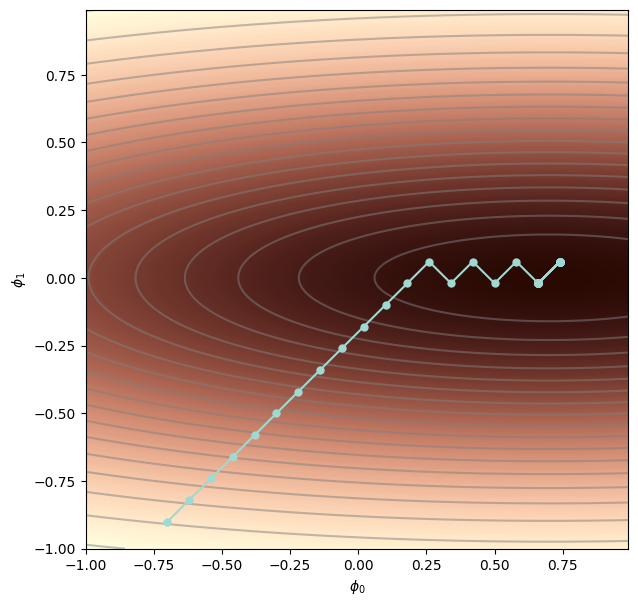

In [83]:
draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path1)


This moves towards the minimum at a sensible speed, but we never actually converge -- the solution just bounces back and forth between the last two points.  To make it converge, we add momentum to both the estimates of the gradient and the pointwise squared gradient.  We also modify the statistics by a factor that depends on the time to make sure the progress is not slow to start with.

#### 3.2.2 Complete the below code for Adam

The Adam optimizer update rules are:

$$
m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t
$$

$$
v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2
$$

Where:
- $ m_t $ is the first moment estimate (exponentially decaying average of past gradients).
- $ v_t $ is the second moment estimate (exponentially decaying average of past squared gradients).
- $ g_t $ is the gradient at time step $ t $.

Bias correction:

$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}
$$


$$
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$

Where:
- $ \hat{m}_t $ is the bias-corrected first moment estimate.
- $ \hat{v}_t $ is the bias-corrected second moment estimate.

The parameter update rule is:

$$
\theta_{t+1} = \theta_t - \frac{\alpha}{ \sqrt{ \hat{v}_t } + \epsilon} \cdot \hat{m}_t
$$

Where:
- $ \theta_t $ is the parameter at time step $ t $.
- $ \alpha $is the learning rate.
- $ \epsilon $ is a small constant to prevent division by zero.
  

<!-- BEGIN QUESTION -->



In [84]:
def adam(start_posn, n_steps, alpha,  beta=0.9, gamma=0.99, epsilon=1e-20):
    grad_path = np.zeros((2, n_steps+1));
    grad_path[:,0] = start_posn[:,0];

    m = np.zeros_like(grad_path[:,0])
    v = np.zeros_like(grad_path[:,0])

    for c_step in range(n_steps):

        # Measure the gradient
        grad = get_loss_gradient(grad_path[0,c_step], grad_path[1,c_step])

        # TODO -- Update the momentum based gradient estimate equation 6.15 (first line)
        # Replace this line:
        m = beta * m + (1 - beta) * grad


        # TODO -- update the momentum based squared gradient estimate as in equation 6.15 (second line)
        # Replace this line:
        v = gamma * v + (1 - gamma) * np.square(grad)

        # TODO -- Modify the statistics according to equation 6.16
        # You will need the function np.power
        # Replace these lines
        m_tilde = m / (1 - np.power(beta, c_step+1))
        v_tilde = v / (1 - np.power(gamma, c_step+1))


        # TODO -- apply the update rule (equation 6.17)
        # Replace this line:
        grad_path[:,c_step+1] = grad_path[:,c_step] - alpha * m_tilde / (np.sqrt(v_tilde) + epsilon)

    return grad_path;


<!-- END QUESTION -->



In [85]:
# Let's try out our Adam algorithm

start_posn = np.zeros((2,1));
start_posn[0,0] = -0.7; start_posn[1,0] = -0.9


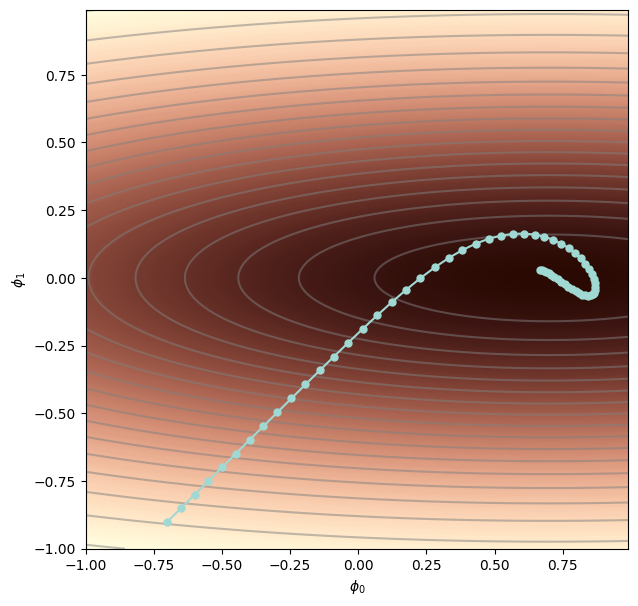

In [86]:
# Run gradient descent

grad_path1 = adam(start_posn, n_steps=60, alpha = 0.05)
draw_function(phi0mesh, phi1mesh, loss_function, my_colormap, grad_path1)
